# AI Hallucination Cases Data Analysis

## Data

[Damien Charlotin’s AI Hallucination Cases database](https://www.damiencharlotin.com/hallucinations/) compiles various cases where attorneys came under fire for letting AI hallucinations appear in their legal deliverables.

## Hypotheses

Null Hypothesis: All AI tools have been equally frequently associated with the hearings, or outcomes, faced by attorneys.

Alternative Hypothesis: Certain AI tools have been more frequently associated with certain attorney outcomes than others.   

Exploring Data

In [80]:
df = pd.read_csv('Charlotin-hallucination_cases.csv')

df.head()

,Case Name,Court,State(s),Date,Party(ies),AI Tool,Hallucination,Outcome,Monetary Penalty,Professional Sanction,Key Principle,Pointer,Source,Details
0,In re Marla C. Martin,N.D. Illinois (Bankruptcy),USA,2025-07-18,Lawyer,ChatGPT,Fabricated citation(s),"Sanction of $5,500 and mandatory AI education",5500 USD,Yes,NaN,Volokh,https://reason.com/volokh/2025/07/19/any-lawye...,"""The first reason I issue sanctions stems from..."
1,Jordan et al. v. Chicago Housing Authority,Cook County District Court,USA,2025-07-17,Lawyer,ChatGPT,Fabricated citation,Order to show cause,NaN,No,NaN,NaN,https://www.yahoo.com/news/lawyers-chicago-hou...,"According to local press, counsel was called t..."
2,Hatfield v. Ornelas,NaN,USA,2025-07-16,Pro Se Litigant,Unidentified,Fabricated citation(s),Order to Show Cause,NaN,No,NaN,NaN,/documents/594/Hatfield_v_7Wnj8QP._Cesar_Ornel...,NaN
3,USA v. McGee et al.,Alabama D.C.,USA,2025-07-16,Lawyer,Ghostwriter Legal,Fabricated cases,Counsel removed from the case,NaN,No,NaN,NaN,NaN,"Folllowing a show cause order, Counsel admitte..."
4,Blaser v. Campbell,Civil Resolution Tribunal,Canada,2025-07-15,Pro Se Litigant,Implied,Fabricated citation(s),Warning,NaN,No,NaN,NaN,/documents/590/Blaser_v._Campbell_Canada_15_Ju...,NaN


In [81]:
df_copy = df.dropna(subset=['Outcome'])

for i in range(10):
  print(df_copy.loc[df_copy['Outcome'].str.contains(';'), 'Outcome'].iloc[i])
  print()

Motion Record removed from Court file; costs awarded to Applicant

Order of costs to other party; no professional referral

Order to show cause issued; potential striking of motion

Case remanded; monetary penalty

Motion is dismissed; Order to show cause

CLE Course obligation; endorsement of decision not to bill client

Warning; No costs awarded for the appeal since both sides seemingly erred

Appeal was ultimately dismissed on merits; Monetary sanction

Breach of Rule 11, but no monetary sanction warranted; referred counsel to Lawyers Professional Responsibility Board

Plaintiff’s application dismissed; no costs imposed; court warns against future use of generative AI without verification



In [85]:
df['AI Tool'].co

34

## Methodology

Since `df['Outcomes']` contains outcomes in natural language which is inconsistent from row to row. In order to count how many times each outcome occurred on using each AI tool, I will need to make the outcomes consistent across rows. For this, I can try using topic modeling to identify the most common outcomes then use a LLM to automatically classify each row into applicable common outcomes.

Finding the most outcomes in `df['Outcomes']` through Topic Modeling.

In [41]:
!pip install gensim

In [44]:
import pandas as pd
import os, nltk, json, csv
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')
from collections import Counter
import csv
import gensim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [46]:
stop_words = nltk.corpus.stopwords.words('english')

with open('./stop_words.csv', 'w', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(stop_words)
print('NLTK stopwords list saved to stopwords.csv.')

NLTK stopwords list saved to stopwords.csv.


In [47]:
def process_token(token):
    token = token.lower()
    if token in stop_words:
        return
    if len(token) < 4:
        return
    if not(token.isalpha()):
        return
    return token

documents = []

details_texts = df['Outcome'].dropna().tolist()

processed_count = 0
for text in details_texts:
    raw_unigrams = nltk.word_tokenize(text)

    processed_unigrams = [process_token(token) for token in raw_unigrams if process_token(token) is not None]

    documents.append(processed_unigrams)

    processed_count += 1

print(f'{len(documents)} documents processed and added to the "documents" list.')

218 documents processed and added to the "documents" list.


In [48]:
dictionary = gensim.corpora.Dictionary(documents)

doc_count = len(documents)
num_topics = 7
passes = 5
dictionary.filter_extremes(no_below=2, no_above=0.90)

bow_corpus = [dictionary.doc2bow(doc) for doc in documents]

In [49]:
%%time
# Train the LDA model
model = gensim.models.LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=passes
)

CPU times: user 646 ms, sys: 3.55 ms, total: 650 ms
Wall time: 755 ms


In [50]:
from gensim.models.coherencemodel import CoherenceModel # Import CoherenceModel

# Compute the coherence score using UMass
# u_mass is measured from -14 to 14, higher is better
coherence_model_lda = CoherenceModel(
    model=model,
    corpus=bow_corpus,
    dictionary=dictionary,
    coherence='u_mass'
)

# Compute Coherence Score using UMass
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -14.214344147029479


In [51]:
for topic_num in range(0, num_topics):
    word_ids = model.get_topic_terms(topic_num)
    words = []
    for wid, weight in word_ids:
        word = dictionary.id2token[wid]
        words.append(word)
    print("Topic {}".format(str(topic_num).ljust(5)), " ".join(words))

Topic 0     dismissed judicial imposed application court costs appeal evidence record petition
Topic 1     warning monetary dismissed sanction case sanctions counsel legal costs merits
Topic 2     fine case appeal monetary referred awarded value dismissal court client
Topic 3     plaintiff monetary expert striking brief fees attorney response defendant costs
Topic 4     citations submissions ignored fake motion ordered plaintiff court referral sanction
Topic 5     sanction formal monetary court warning judicial referral imposed issued reprimand
Topic 6     order cause show costs sanctions motion potential client filing striking


Creating a dashboard for visualizing the leading outcomes

In [52]:
!pip install pyLDAvis

In [53]:
import pyLDAvis.gensim
import os

# Create the directory if it doesn't exist
os.makedirs('./data/', exist_ok=True)

# Export this visualization as an HTML file
# An internet connection is still required to view the HTML
p = pyLDAvis.gensim.prepare(model, bow_corpus, dictionary)
pyLDAvis.save_html(p, './data/my_visualization.html')

**Automatic classification using a LLM:** Unfortunately, as visible below, a vast majority of entries in `df['AI Tool']` are either 'Implied' or 'Unidentified,' making it difficult to tell if certain AI tools are more associated with certain outcomes.

Nevertheless, since my main objective was to gain experience with the data analysis techiques, I will continue with the project, capping the number of rows per AI tool group at 2, the maximum number of rows that can be found for the 5 most represented AI tools.

In [110]:
top_5_ai_tools = df['AI Tool'].value_counts().head(5)

print(top_5_ai_tools)

AI Tool
Implied         92
Unidentified    66
ChatGPT         30
Copilot          2
Claude           2
Name: count, dtype: int64


In [116]:
top_5_ai_tools = df['AI Tool'].value_counts().index.tolist()[:5]
print(top_5_ai_tools)

['Implied', 'Unidentified', 'ChatGPT', 'Copilot', 'Claude']


In [57]:
!pip install dotenv

In [122]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path="key.env")
api_key = os.getenv("OPENAI_API_KEY")
base_url = os.getenv("BASE_URL")

leading_outcomes = ['warning', 'sanction', 'order to show cause', 'dismissed', 'other']

sys_msg = f"""Categorize this output of a court case.
Please respond only with one word from {', '.join(leading_outcomes[:-1])}, or {leading_outcomes[-1]}."""

print(sys_msg)

client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

def make_completion(user_msg, model='gemini-2.5-flash', print_msg=False):
  completion = client.chat.completions.create(
    model=model,

    messages=[
      {"role": "system", "content": sys_msg},
      {"role": "user", "content": user_msg}
    ]
  )
  if print_msg:
    print(f"System message: {sys_msg}\n{'-' * 80}") # print system message
    print(f"User message: {user_msg}\n{'-' * 80}") # print user message
    print(
        f"Assistant response: {completion.choices[0].message.content}\n{'*' * 80}" # get the LLM response
    )

    return completion.choices[0].message.content
  return completion.choices[0].message.content

df_copy = df[df['AI Tool'].isin(top_5_ai_tools)]

sample_df = df_copy.dropna(subset=['Outcome']).groupby('AI Tool').sample(n=2, random_state=84)

sample_df['LLM_output'] = sample_df['Outcome'].apply(make_completion)

Categorize this output of a court case.
Please respond only with one word from warning, sanction, order to show cause, dismissed, or other.


In [118]:
df_copy.head()

,Case Name,Court,State(s),Date,Party(ies),AI Tool,Hallucination,Outcome,Monetary Penalty,Professional Sanction,Key Principle,Pointer,Source,Details
0,In re Marla C. Martin,N.D. Illinois (Bankruptcy),USA,2025-07-18,Lawyer,ChatGPT,Fabricated citation(s),"Sanction of $5,500 and mandatory AI education",5500 USD,Yes,NaN,Volokh,https://reason.com/volokh/2025/07/19/any-lawye...,"""The first reason I issue sanctions stems from..."
1,Jordan et al. v. Chicago Housing Authority,Cook County District Court,USA,2025-07-17,Lawyer,ChatGPT,Fabricated citation,Order to show cause,NaN,No,NaN,NaN,https://www.yahoo.com/news/lawyers-chicago-hou...,"According to local press, counsel was called t..."
2,Hatfield v. Ornelas,NaN,USA,2025-07-16,Pro Se Litigant,Unidentified,Fabricated citation(s),Order to Show Cause,NaN,No,NaN,NaN,/documents/594/Hatfield_v_7Wnj8QP._Cesar_Ornel...,NaN
4,Blaser v. Campbell,Civil Resolution Tribunal,Canada,2025-07-15,Pro Se Litigant,Implied,Fabricated citation(s),Warning,NaN,No,NaN,NaN,/documents/590/Blaser_v._Campbell_Canada_15_Ju...,NaN
5,ByoPlanet International v. Johansson and Gilstrap,"United States District Court, Southern Distric...",USA,2025-07-15,Lawyer; Paralegal,ChatGPT,Fabricated citation(s),"Cases dismissed without prejudice, attorney or...",1 USD,Yes,NaN,NaN,/documents/597/Byoplanet_Order.pdf,"In May, the court asked Counsel to show cause ..."


In [119]:
sample_df.head()

,Case Name,Court,State(s),Date,Party(ies),AI Tool,Hallucination,Outcome,Monetary Penalty,Professional Sanction,Key Principle,Pointer,Source,Details,LLM_output
138,Arnaoudoff v. Tivity Health Incorporated,D. Arizona,USA,2025-03-11,Pro Se Litigant,ChatGPT,Fake citations,Court ignored fake citations and granted motio...,NaN,No,NaN,NaN,/documents/369/Arnaoudoff_v._Tivity_Health_Inc...,NaN,Other\n
26,Doe v. Noem,D.C. DC,USA,2025-07-01,Lawyer,ChatGPT,One fabricated authority,Order to Show Cause,NaN,No,NaN,NaN,NaN,"Fake citation, in this brief, was to : Moms Ag...",Order to show cause\n
41,"Mintvest Capital, LTD v. NYDIG Trust Company, ...",D.C. Puerto Rico,USA,2025-06-23,Lawyer,Claude,"Fabricated citations, false quotes, and misrep...",Order to pay opposing counsel's fees,1 USD,No,NaN,NaN,/documents/561/Mintvest_Capital_LTD_v._NYDIG_T...,Plaintiff's counsel in the case of Mintvest Ca...,Sanction\n
175,Gauthier v. Goodyear Tire & Rubber Co.,E.D. Tex.,USA,2024-11-25,Lawyer,Claude,Two nonexistent cases + multiple fabricated qu...,Monetary fine + Mandatory AI-related CLE Cours...,2000 USD,No,Failure to verify AI outputs violates Rule 11 ...,NaN,https://www.damiencharlotin.com/documents/238/...,AI UseMonk admitted using the Claude AI tool t...,Sanction\n
152,QWYN and Commissioner of Taxation,Administrative Review Tribunal of Australia,Australia,2025-02-05,Lawyer,Copilot,"Copilot, generated a fabricated paragraph from...",The Tribunal affirmed the decision under revie...,NaN,No,NaN,NaN,/documents/542/QWYN_and_Commissioner_of_Taxati...,"""The Applicant engaged the Copilot [Microsoft’...",Other\n


In [123]:
sample_df['LLM_output'].head()

,LLM_output
138,other
26,order to show cause
41,Sanction
175,sanction
152,dismissed


Visualizing the distribution of outcomes associated with each AI tool using a grouped bar plot

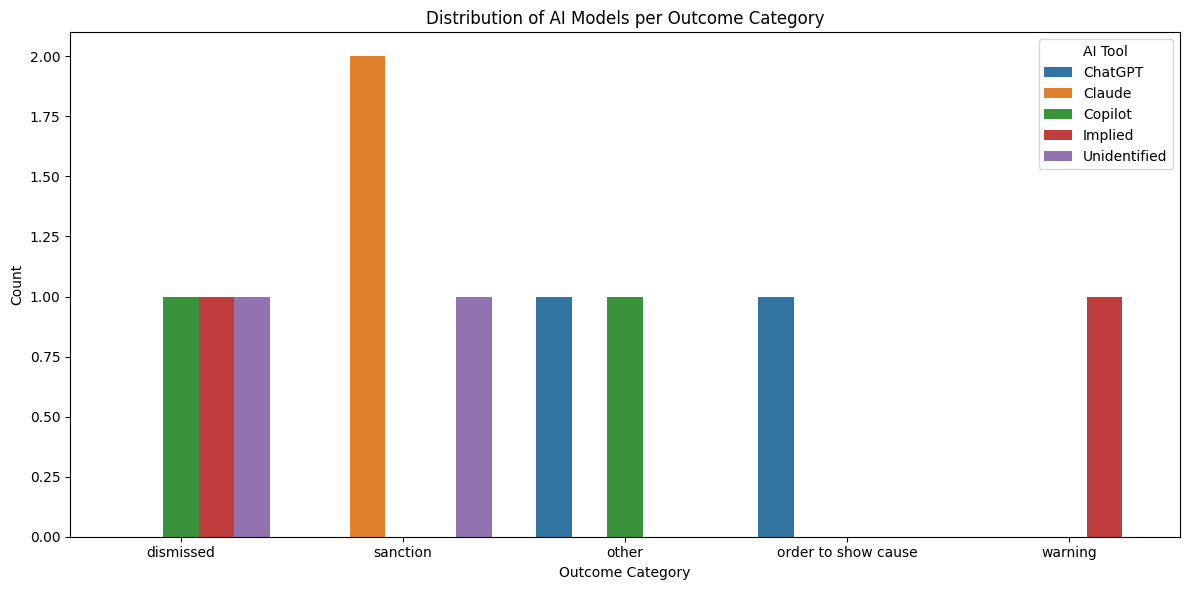

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

sample_df['LLM_output'] = sample_df['LLM_output'].str.lower()

outcome_counts = sample_df.groupby(['AI Tool', 'LLM_output']).size().reset_index(name='Count')

outcome_order = outcome_counts.groupby('LLM_output')['Count'].sum().sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
sns.barplot(data=outcome_counts, x='LLM_output', y='Count', hue='AI Tool', order=outcome_order)
plt.title('Distribution of AI tools per Outcome Category')
plt.xlabel('Outcome Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Results:

Based on the resulting graph, it seems Claude has a more frequent association with sanctions than other AI tools, while for all other leading outcomes, the distribution of associated AI tools is uniform. Assuming the data was sufficient, since one AI tool appears to be more frequently associated with an outcome than others, we would likely reject the null hypothesis after performing a statistical analysis.

### Conclusion:

Since the data on AI tools and associated outcomes was highly limited (only 2 rows could be sampled for some AI tools), it is difficult to tell if any tool caused their attorneys to face an outcome more often than other tools. This project can be improved by doing a further search for data sources with a higher represented of identified AI tools. I can also use statistical analysis to ensure that any tools caused their attorneys to face an outcome more often than other tools.